# Tecan Plate Reader - Growth Assays 

### Background:
This notebook is the template for analysing growth assays from the Tecan plate reader  

### Usage: 
* Input file path of the .csv output straight from the Tecan plate reader in cell 1 under the variable, 'input_file' 

Fns: 
1. `plot_all(df, title)` 
    * Output = Plot of all wells through time 
    * df = generated by running cell 2, so pass as df 
    * Title = string for the graph title, pass string between quotations 
    * Warning!: wells are not averaged, wells are not background substracted   
    e.g. `plot_all(df, 'Growth Assay')`
2. `basic_plot_wells(df, wells, labels,title)`
    * Output = Individual plots of wells through time 
    * df = generated by running cell 2, so pass as df 
    * wells = list of well names to plot (as strings) 
    * Warning!: wells are not averaged, wells are not background substracted  
    e.g. `basic_plot_wells(df, ['A1', 'A2', 'A3'], ['exp1', 'exp2', 'exp3'], 'Growth Assay Ind. Wells')`
3. `adv_plot_wells(df, background_wells, wells, labels, title)`
    * Output = publishable graph of specific wells 
    * df = generated by running cell 2, so pass as df 
    * background_wells = list of well names relating to the replicate wells that measure the OD of background media 
    * wells = list of lists of the specific well names relating to a particular experiment on the plate, where the list within the list contains the well ids for the replicate for that experiment
    * labels = list of strings for the names of the experiments passed into wells 
    * title = string for the title of the graph 
    * Data for wells is background substracted and a ribbon plotted for 1 sigma as calculated from replicates   
    e.g. `adv_plot_wells(df, ['C1', 'C2', 'C3'], [['E2', 'F2', 'G2'], ['E3', 'F3', 'G3']], ['experiment 1', 'experiment 2'], 'title')`

      



In [4]:
# Put file location here of .csv file 
input_file = r'C:/Users/James/Documents/PhD/LeuOMeRS-System/plate_reader_assay/raw/03_06_21_plate_assay_2.csv'
import pandas as pd
df = pd.read_csv(input_file)
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Note on Excel Sheet Formatting: 
## If the plate reader is interrupted before complete run it will inject information between the start time and the cycle data which will prevent script from functioning. 
## **Make sure 'Cycle Nr.' appears on 36A!**

In [5]:
# Create the data structure for temp storage [[A1, 0.001, 0.002],[],[],...]
wells = []
i = 0
while i < 96: 
    wells.append([])
    i += 1
# Add the data including label, index 0->96, 0 = A1 and label is 0[0] 
for col in df: 
    i = 37 
    while i <= 132: 
        wells[i-37].append(df[col][i])
        i += 1

# Sorts into structure for df where {A1:[], A2:[], ...}
wells_data = {}
for item in wells: 
    wells_data[item[0]] = item[1:]

# Add Time [s]
wells_data['Time [s]'] = []
for col in df:
    try:
        time = float(df[col][35])
        wells_data['Time [s]'].append(time)
    except: 
        pass
 
# Create the dataframe 
import pandas as pd 
df = pd.DataFrame(wells_data)

# Convert to python float from numpy 64 (otherwise get matplotlib errors)
for col in df: 
    df[col] = pd.to_numeric(df[col],downcast='float')



In [6]:
# Drop the wells not relating to project
def structure_data(df, list):
    
    for well in list:
        try:
            df.pop(well)
        except: 
            raise Exception(well + ': Well was not found.')
            print('well not found')
    
    return df 

<module 'matplotlib.pyplot' from 'C:\\Users\\James\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

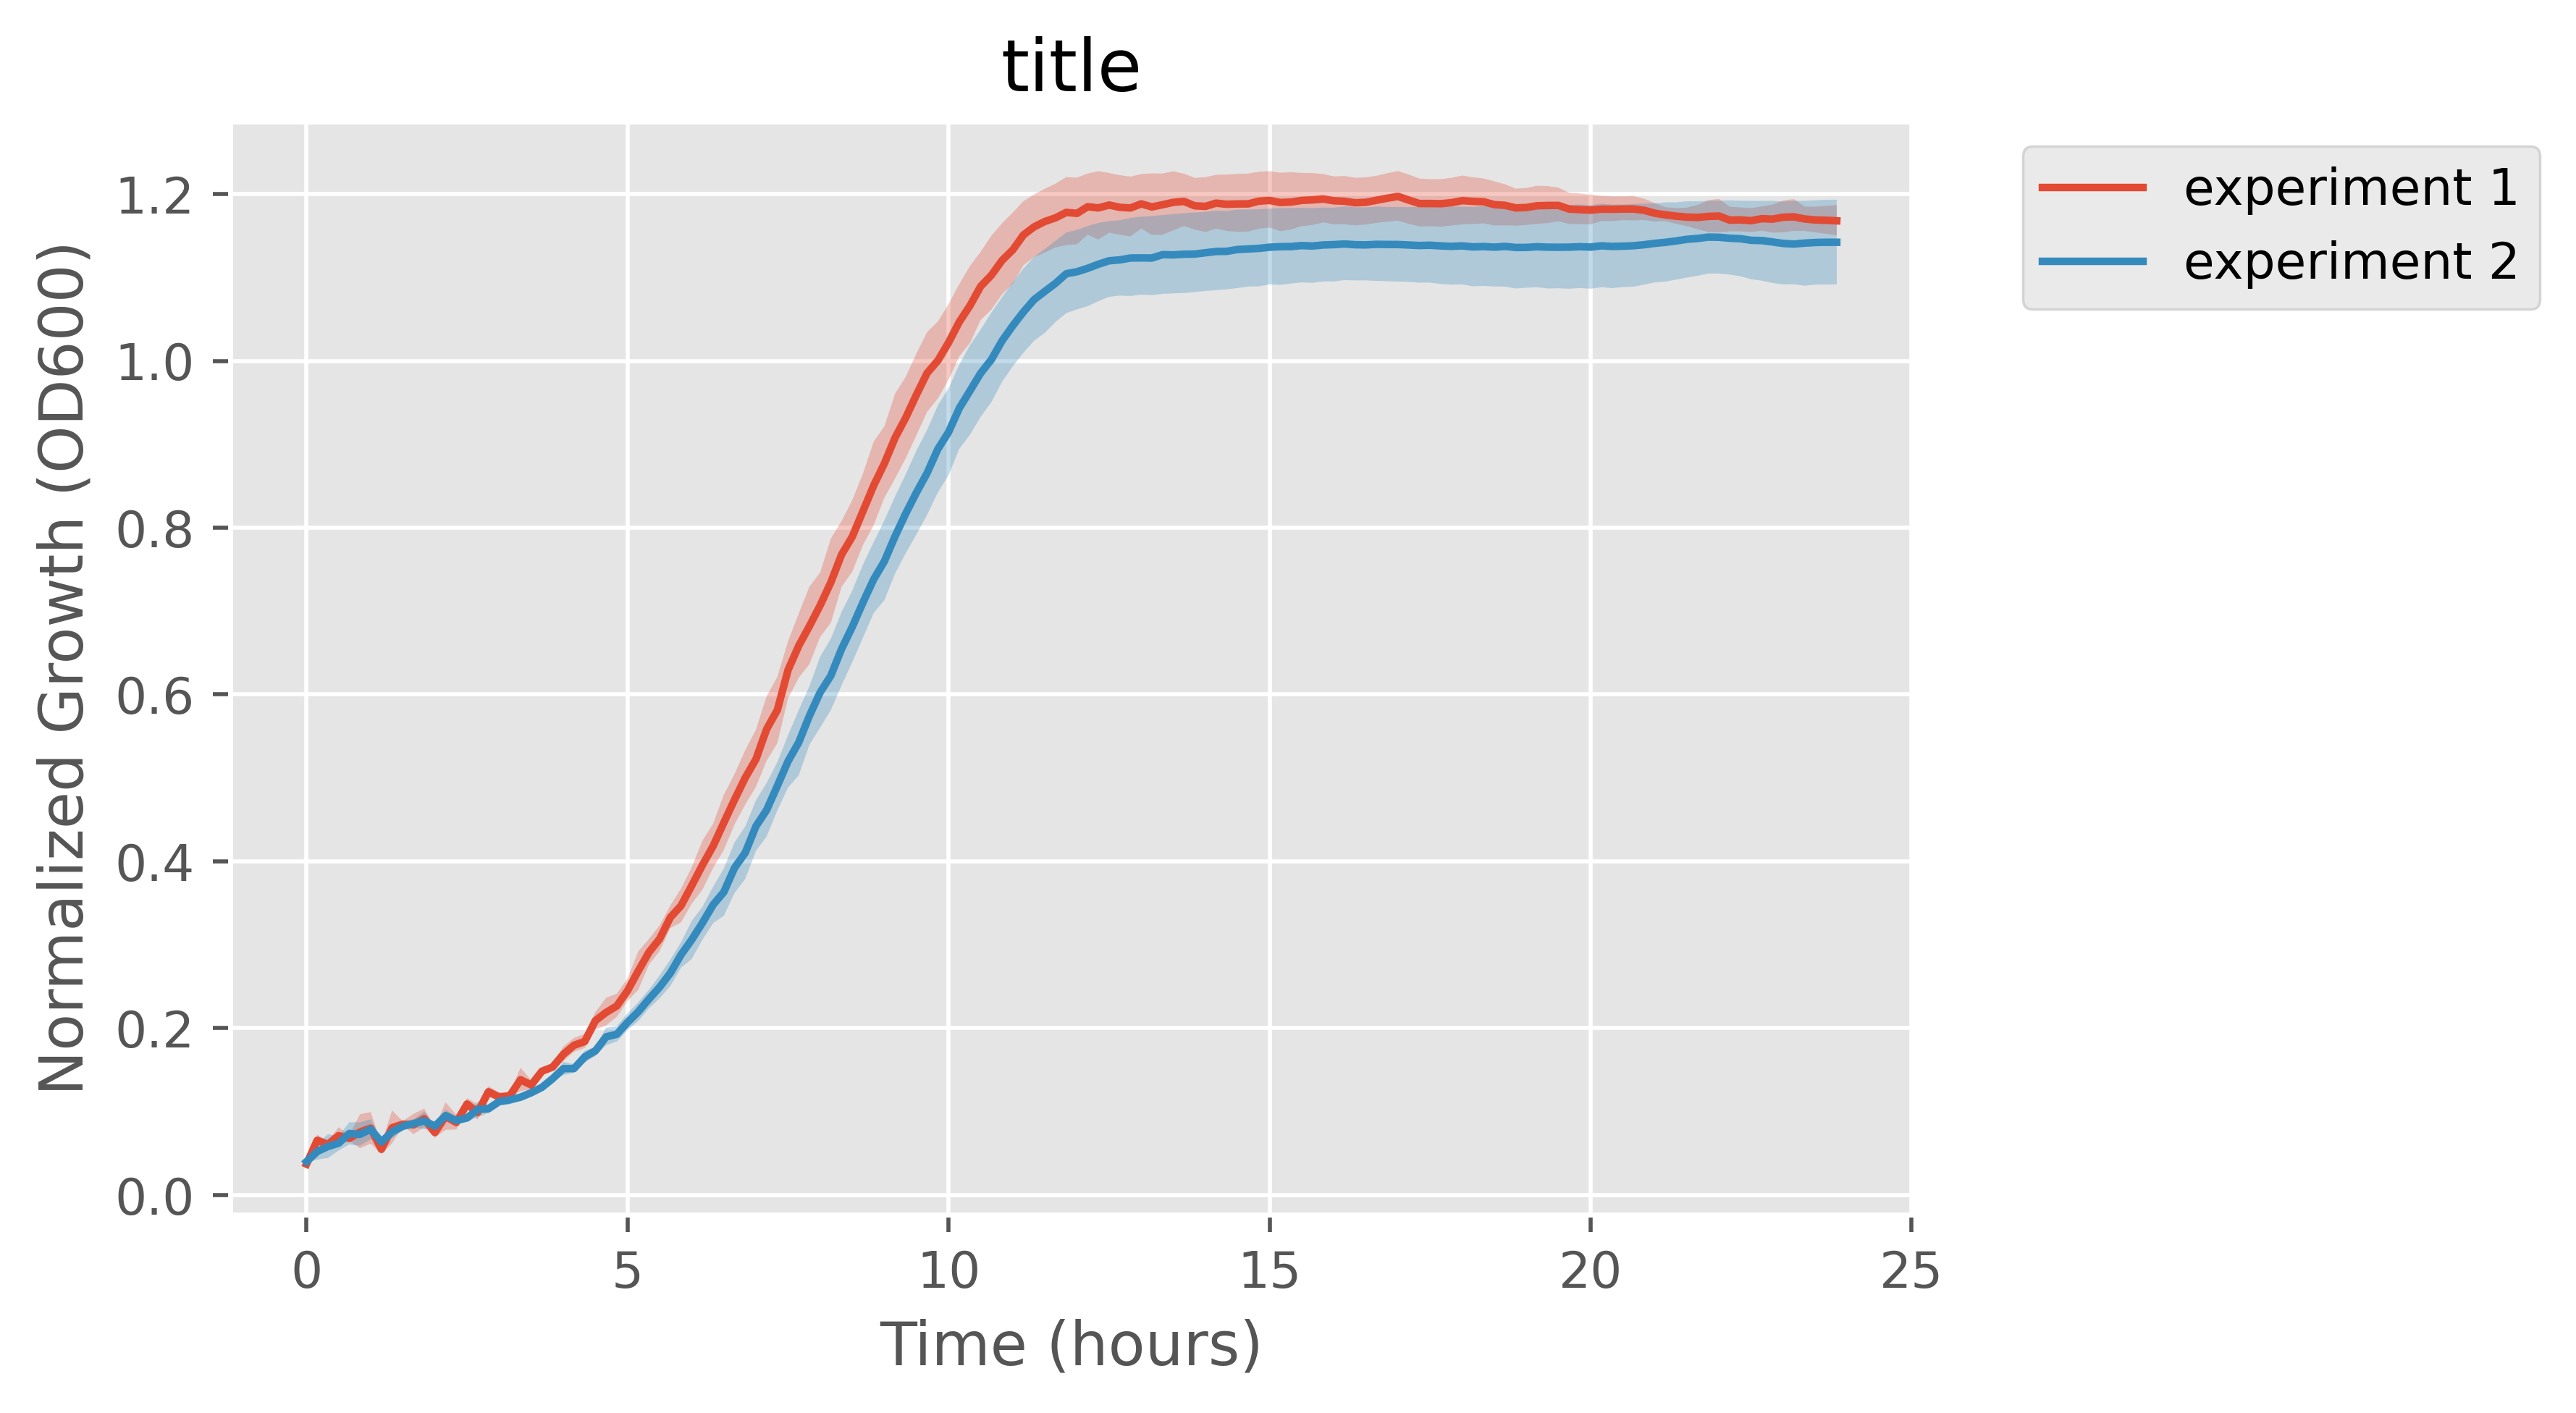

In [7]:
# Plot the graph 
import numpy as np 
import matplotlib.pyplot as plt 
import math
plt.style.use('ggplot')

def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n 
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

def stdev(data): 
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev

def plot_all(df, title):
    
    time = df['Time [s]']
    
    for col in df: 
        if col != 'Time [s]':
            plt.plot(time, df[col])
    
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Growth (OD600)')
    
    return plt.show()
            

def adv_plot_wells(df, background_wells, wells, labels, title):
    # Do this use dataframes dummy 
    
    time_seconds = df['Time [s]']
    
    # Convert seconds series to hours 
    time = []
    for i in time_seconds:
        time.append(i/3600)
        
    # Make a new series of the average for the background wells (media only)
    background_series = [] 
    # Loop through in time and make average across replicates at that time series 
    count = 0 
    while count < len(df[background_wells[0]]):
        avg = 0 
        for well in background_wells: 
            avg += df[well][count]
        avg = avg / len(background_wells)
        background_series.append(avg)
        count += 1
    
    # Find average of replicates across all selected experiments 
    well_avg_series = [] # Holds all experiments and averages over all time [[exp1, exp2, exp3], [exp1, exp2, exp3]]
    count = 0 
    while count < len(df[wells[0][0]]):
        replicates_avgs = [] # Holds the average for all experiments at that time series [exp1, exp2, exp3]
        for experiment in wells: 
            avg = 0 
            for replicate in experiment: 
                avg += df[replicate][count]
            avg = avg / len(experiment)
            replicates_avgs.append(avg)
        well_avg_series.append(replicates_avgs)
        count += 1
     
    # Create data structure for new series where [[experiment 1 normalised + avg ], [experiment 2 normalized + avg]...]
    substracted_series = [] # Holds the data for plotting 
    count = 0 
    while count < len(wells):
        substracted_series.append([])
        count += 1
    
    for entry, background in zip(well_avg_series, background_series):
        count = 0 
        while count < len(wells):
            substracted = entry[count] - background 
            substracted_series[count].append(substracted)
            count += 1
   
    # Caculate stdev for replicates in time 
    stdev_series = [] # Holds stdev for each experiment in time [[time 1 A, time 1 B], [time 2 A, time 2 B] ... ]
    count = 0 
    while count < len(df[wells[0][0]]):
        std_time_series = [] # holds stdev for each experiment at time x 
        for experiment in wells:
            temp_store  = [] # stores data of all replicates at time point
            for replicate in experiment: 
                temp_store.append(df[replicate][count])
            error = stdev(temp_store) # calculate stdev 
            std_time_series.append(error)
        stdev_series.append(std_time_series)
        count += 1    
    
    error_series = [] # Holds upper and lower bounds for time series for each specified experiment [ [ [exp1 L series], [exp1 H series] ], [ [exp2 L series], [exp2 H series] ]
    count = 0 
    while count < len(wells):
        error_series.append([[],[]])
        count += 1
 
    # Loops through well averages and stdev series to make series for upper and lower bounds 
    for std, avg in zip(stdev_series, well_avg_series):
        
        count = 0 
        while count < len(wells):
            upper = avg[count] + std[count]
            lower = avg[count] - std[count]
            
            error_series[count][0].append(lower)
            error_series[count][1].append(upper)
    
            count +=1 
    
  
    # Plot the graph 
    plt.figure(dpi=500)
    for experiment, error, background, label in zip(substracted_series, error_series,background_series, labels):     
        plt.plot(time, experiment, label=label)
        plt.fill_between(time, error[0]-background, error[1]-background, alpha=0.3)
   
    
    plt.xlabel('Time (hours)')
    plt.ylabel('Normalized Growth (OD600)')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')
    
    return plt
    
            
adv_plot_wells(df, ['C1', 'C2', 'C3'], [['E2', 'F2', 'G2'], ['E3', 'F3', 'G3']], ['experiment 1', 'experiment 2'], 'title')

      

    


    
    
    
